In [3]:
from scipy import signal
from scipy.integrate import odeint
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from fractions import Fraction
import scipy.stats as st
from sklearn.utils import resample
from scipy.optimize import curve_fit
import matplotlib
import pickle
from tqdm import tqdm_notebook
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# The HPA response to noise

## Avichai's Model

In [10]:
def get5eqsparams(timescale='day'):
    #parameters are from the paper Mathematical modeling of the hypothalamic-pituitary-adrenal gland (HPA) axis, including hippocampal mechanisms.
    #Andersen M1, Vinther F, Ottesen JT.
    
    a1 = 1/5  # [1/min]
    a2 = 1/30 # [1/min]
    a3 = 1/90 # [1/min]

    #mitosis every 63 days according to Nolan et al
#     aP = 1/60/(60*24)
    aP = 0.099/(60*24) # ~10.1 days - omer's number
#     aP = 1/10/(60*24)    
    
    # turnover of 60 days according to Kataoka et al
#     aA = 1/60/(60*24)
    aA = 0.049/(60*24) # ~20.4 days - omer's number
#     aA = 1/10/(60*24)

    #We normalize all means to 1, we therefore get
    b1=a1; b2=a2; b3=a3; bA=aA; bP=aP;
    
    res = np.array([a1,a2,a3,aA,aP,b1,b2,b3,bA,bP])
    
    if timescale=='hour':
        res = 60*res
    
    if timescale=='day':
        res = 24*60*res
    
    return res

In [103]:
def HPA_slow(y, t, timescale='day', ut=lambda t: 1):

    [a1, a2, a3, aa, ap, b1, b2, b3, ba, bp] = get5eqsparams(timescale)
    [P, A] = y
    u = ut(t)
    
    dP = ap * (u**(2/3)) * (P**(2/3)) * (A**(-1/3)) - ap * P
    dA = aa * (u**(1/3)) * (P**(1/3)) * (A**( 1/3)) - aa * A
    
    return [dP, dA]


def HPA_slow_omer(y, t, ap, aa, ut=lambda t: 1):

    [P, A] = y
    u = ut(t)
    
    dP = ap * (u**(1/2)) * (P**(1/2)) * (A**(-1/2)) - ap * P
    dA = aa * (u**(1/2)) * (P**(1/2)) * (A**( 1/2)) - aa * A
    
    return [dP, dA]


def HPA_slow_mult(y, t, timescale='day', ut=lambda t, N: 1, aa=None, ap=None):

    [a1, a2, a3, aa_tmp, ap_tmp, b1, b2, b3, ba, bp] = get5eqsparams(timescale)
    
    if aa is None:
        aa = aa_tmp
    
    if ap is None:
        ap = ap_tmp
    
    N_vars = 2
    N_vars_mult = len(y)
    
    N_batch = int(N_vars_mult / N_vars)
    
    P = y[:N_batch]
    A = y[N_batch:]
    u = ut(t, N_batch)
    
    dP = ap * (u**(2/3)) * (P**(2/3)) * (A**(-1/3)) - ap * P
    dA = aa * (u**(1/3)) * (P**(1/3)) * (A**( 1/3)) - aa * A
    
    return np.concatenate((dP, dA))


def HPA_fast_mult(y, t, timescale='hour', ut=lambda t, N: 1):

    [a1, a2, a3, aa, ap, b1, b2, b3, ba, bp] = get5eqsparams(timescale)
    N_vars = 3
    N_vars_mult = len(y)
    
    N_batch = int(N_vars_mult / N_vars)
    
    x1 = y[:N_batch]
    x2 = y[N_batch:2*N_batch]
    x3 = y[2*N_batch:3*N_batch]
    P = 1
    A = 1
#     P = y[3*N_batch:4*N_batch]
#     A = y[4*N_batch:]
    u = ut(t, N_batch)
    
    dx1 = u*b1/x3    - a1*x1 # CRH
    dx2 = b2*x1*P/x3 - a2*x2 # ACTH
    dx3 = b3*x2*A    - a3*x3 # Cortisol
#     dP = P*(bp*x1 - ap)      # Pituitary cells
#     dA = A*(ba*x2 - aa)      # Adrenal cells
    
    return np.concatenate((dx1, dx2, dx3))


def HPA_full_mult(y, t, timescale='day', ut=lambda t, N: 1):

    [a1, a2, a3, aa, ap, b1, b2, b3, ba, bp] = get5eqsparams(timescale)
    N_vars = 5
    N_vars_mult = len(y)
    
    N_batch = int(N_vars_mult / N_vars)
    
    x1 = y[:N_batch]
    x2 = y[N_batch:2*N_batch]
    x3 = y[2*N_batch:3*N_batch]
    P = y[3*N_batch:4*N_batch]
    A = y[4*N_batch:]
    u = ut(t, N_batch)
    
    dx1 = u*b1/x3    - a1*x1 # CRH
    dx2 = b2*x1*P/x3 - a2*x2 # ACTH
    dx3 = b3*x2*A    - a3*x3 # Cortisol
    dP = P*(bp*x1 - ap)      # Pituitary cells
    dA = A*(ba*x2 - aa)      # Adrenal cells
    
    return np.concatenate((dx1, dx2, dx3, dP, dA))


def calculate_hormones(P, A, u):
    '''
    P / A / u - [N_time X N_signals]
    
    return:
        hormones - [3 X N_time X N_signals]
    '''
    
    x1 = ( u**2 * (1/P) * (  1/A   ) ) ** (1/3)
    x2 = ( u    *   P   * (1/(A**2)) ) ** (1/3)
    x3 = ( u    *   P   *     A      ) ** (1/3)
    
    return np.array([x1, x2, x3])

## Omer's Model

In [72]:
omer_pars = dict(   # days
    [
        ("gamma_h", np.log(2)/4*24*60),
        ("gamma_p", np.log(2)/20*24*60),
        ("gamma_a", np.log(2)/80*24*60),
        ("gamma_P", np.log(2)/7),
        ("gamma_A", np.log(2)/14),
        ("gamma_R", 0),
        ("gamma_CR", 0),
        ("gamma_external_CRH", np.log(2)/43*24*60)
    ]
)

pars = omer_pars.copy()

pars_no_turnover = pars.copy()
pars_no_turnover.update({"gamma_P" : 0, "gamma_A" : 0})

pars_gr_resistance = pars_no_turnover.copy()
pars_gr_resistance.update({"gamma_R" : np.log(2)/(30*24*60)})

pars_cr = pars_no_turnover.copy()
pars_cr.update({"gamma_CR" : np.log(2)/(30*24*60)})

names = ["CRH","ACTH","cortisol","corticotroph mass",
         "adrenal mass","external_CRH","stimulation (u)"]

MR = lambda a: np.divide(1, np.power(a, 1))
GR = lambda a, kGR: np.divide(1, np.power(np.divide(a, kGR), 3) + 1)

def eqs(h, p, a, P, A,R,CR,ext_crh,kGR,u,external_crh,pars,t):
    stim_crh = h+ext_crh
    return [pars["gamma_h"]*(u(t)*MR(a)*GR(a,kGR/R)-h), 
            pars["gamma_p"]*(stim_crh*GR(a,kGR/R)*P-p), 
            pars["gamma_a"]*(A*p-a/CR),
            pars["gamma_P"]*P*(stim_crh-1),
            pars["gamma_A"]*A*(p-1),
            pars["gamma_R"]*(1-(1+a**2)*R),
            pars["gamma_CR"]*(a-CR),
            pars["gamma_external_CRH"] * (external_crh(t) - ext_crh)]


def pend(y,t,kGR,u,external_crh,pars):
    h, p, a, P, A,R,CR,ext_crh = y
    dydt = eqs(h, p, a, P, A,R,CR,ext_crh,kGR,u,external_crh,pars,t)
    
    return dydt


def eqs_simple(y, t, ut=lambda t, N: 1, pars=pars, kGR=4):
    
    N_vars = 5
    N_vars_mult = len(y)
    
    N_batch = int(N_vars_mult / N_vars)
    
    x1 = y[:N_batch]
    x2 = y[N_batch:2*N_batch]
    x3 = y[2*N_batch:3*N_batch]
    P = y[3*N_batch:4*N_batch]
    A = y[4*N_batch:5*N_batch]
    u = ut(t, N_batch)
    
    return np.concatenate([
        pars["gamma_h"]*(u*MR(x3)*GR(x3, kGR) - x1), 
        pars["gamma_p"]*(x1*P*GR(x3, kGR) - x2), 
        pars["gamma_a"]*(x2*A - x3),
        pars["gamma_P"]*P*(x1 - 1),
        pars["gamma_A"]*A*(x2 - 1)
    ])


def omer_no_gland_dynamics(y, t, ut=lambda t, N: 1, pars=pars, kGR=4):
    
    N_vars = 3
    N_vars_mult = len(y)
    
    N_batch = int(N_vars_mult / N_vars)
    
    x1 = y[:N_batch]
    x2 = y[N_batch:2*N_batch]
    x3 = y[2*N_batch:3*N_batch]
    u = ut(t, N_batch)
    
    return np.concatenate([
        pars["gamma_h"]*(u*MR(x3)*GR(x3, kGR) - x1), 
        pars["gamma_p"]*(x1*GR(x3, kGR) - x2), 
        pars["gamma_a"]*(x2 - x3),
    ])

## Cortisol's frequency response

In [41]:
def insert_decay(data, t, A0, alpha, plot=False, plot_log=False, n2plot=10):
    '''
    multiplies each column of data by A0*exp(-alpha*t)
    
    @params:
        data - [#time X #samples]
        A0 / alpha - the exponent parameters. Can be either:
            1. distributions and then they should be scipy.stats object
            2. list of parameters, and then each list should be in the length of data.shape[1]
            
    '''
    
    N_samples = data.shape[1]
    if not isinstance(A0, (np.ndarray, list)):
        A0 = A0.rvs(size=N_samples)
    
    if not isinstance(alpha, (np.ndarray, list)):
        alpha = alpha.rvs(size=N_samples)
    
    decaying_signal = data * A0 * np.exp(-np.outer(t, alpha))
    
    if plot:
        plt.figure()
        plt.plot(t, decaying_signal[:, :n2plot])
        plt.xlabel('time')
        plt.title('decaying signal')
        if plot_log:
            plt.yscale('log')
        plt.show()
        
    return decaying_signal

In [45]:
def average_bimonthly(data, time_spacing, time_unit='day', plot=False, plot_log=False, n2plot=10):
    '''
    @params:
        data - [#time X #subjects]
        time_spacing - the time interval between 2 data points
        time_unit - 'day' / 'min'
    
    @returns:
        t_bimonths
        bimonthly_data
    '''
    
    if time_unit == 'day':
        bimonths = 60
    elif time_unit == 'min':
        bimonths = 60 * 24 * 60
    else:
        raise ValueError('receive time_unit = {}. should be day or min'.format(time_unit))
    
    N_bimonths = int(round((data.shape[0] - 1) * time_spacing / bimonths))
    t_bimonths = np.arange(N_bimonths) * bimonths + int(bimonths/2)
    bimonthly_data = np.vstack(
        [np.mean(data[int(i*bimonths/time_spacing):int((i+1)*bimonths/time_spacing)], axis=0) for i in range(N_bimonths)]
    )
    
    if plot:
        plt.figure()
        plt.plot(t_bimonths, bimonthly_data[:, :n2plot])
        plt.title('bimonthly cortisol')
        plt.xlabel('time')
        if plot_log:
            plt.yscale('log')
        plt.show()
    
    return t_bimonths, bimonthly_data

In [47]:
def normalize_hair_cortisol(data, sample_stat='mean', steps=2, mean_type='r', plot=False):
    '''
    data: [#timepoints X #samples]
    sample_stat: the individial statistic to normalize with. can be 'mean' or 'first' (first measure) or 'max'
    steps: 1 - normalizing just by the segment's mean, 2 - normalizing each subject by sample_stat and then by the segment mean
    mean_type: 'r' - regular mean, 'g' - geometric mean
    '''
    
    if steps == 2:
        if sample_stat == 'mean':
            normalization_factor = np.nanmean(data, axis=0)
        elif sample_stat == 'first':
            normalization_factor = data[0]
        elif sample_stat == 'max':
            normalization_factor = np.nanmax(data, axis=0)
        else:
            raise ValueError('normalization by {} is not supported'.format(sample_stat))
            
        normalized_by_sample_stat = data / normalization_factor
        
    elif steps == 1:
        normalized_by_sample_stat = data
        
    else:
        raise ValueError('steps should be 1 or 2')
    
    if mean_type == 'g':
        mean_name = 'geometric'
        estimated_decaying_factors = st.gmean(normalized_by_sample_stat, axis=1)
        estimated_decaying_factors_err = st.gstd(normalized_by_sample_stat, axis=1)
    else:
        mean_name = 'arithmetic'
        estimated_decaying_factors = np.nanmean(normalized_by_sample_stat, axis=1)
        estimated_decaying_factors_err = st.sem(normalized_by_sample_stat, axis=1)
    
    estimated_signal = normalized_by_sample_stat / estimated_decaying_factors[:, np.newaxis]
    
    if plot:
        N = data.shape[1]
        f, axs = plt.subplots(1, 4, sharex=True, figsize=(22,5))
        axs[0].plot(data[:, :10])
        axs[0].set_title('Raw data (N={})'.format(N), size=14)
        
        axs[1].plot(normalized_by_sample_stat[:, :10])
        axs[1].set_title('Normalized by sample {}'.format(sample_stat), size=14)
                    
        axs[2].errorbar(np.arange(data.shape[0]), estimated_decaying_factors, yerr=estimated_decaying_factors_err)
        axs[2].set_title('Estimated decay ({} mean)'.format(mean_name), size=14)
        
        axs[3].plot(estimated_signal[:, :10])
        axs[3].set_title('Estimated signal', size=14)
    
    return estimated_signal


def rank_normalize_hair_cortisol(data, plot=False):
    '''
    data: [#timepoints X #samples]
    '''
    
    ranked_data = st.rankdata(data).reshape(data.shape)
    mean_ranked_data = np.mean(ranked_data, axis=1)
    normalized = ranked_data - mean_ranked_data[:, np.newaxis]
    
    if plot:
        N_subjects = data.shape[1]
        N_timepoint = data.shape[0]
        f, axs = plt.subplots(1, 4, sharex=True, figsize=(22, 4))
        axs[0].plot(data)
        axs[0].set_title('Raw data (N={})'.format(N_subjects), size=14)
        
        axs[1].plot(ranked_data)
        axs[1].scatter(np.arange(N_timepoint), mean_ranked_data, s=50)
        axs[1].set_title('Ranked data', size=14)
        
        axs[2].plot(normalized)
        axs[2].set_title('Ranked data - <ranked data>$_{segment}$', size=14)
    
    return normalized


def normalize_by_fitting(data, t, sigma=None, bounds=(-np.inf, np.inf), plot=False, n2plot=10):
    '''
    normalizes the data by canceling the exponential component of it
    
    @params:
        data - [#time X #samples]
        sigma - A 1-d `sigma` should contain values of standard deviations of errors in `ydata`.
                In this case, the optimized function is ``chisq = sum((r / sigma) ** 2)``
        bounds - 2-tuple of array_like, optional
                 Lower and upper bounds on parameters. Defaults to no bounds.
                 Each element of the tuple must be either an array with the length equal
                 to the number of parameters, or a scalar (in which case the bound is
                 taken to be the same for all parameters.) Use ``np.inf`` with an
                 appropriate sign to disable bounds on all or some parameters.
        
    @return:
        normalized data - data.shape
        fitted params - [#samples X #params]
        params_std
    '''
    
    linear = lambda t, A, alpha: np.log(A) - alpha*t

    fitted_params = np.zeros((data.shape[1], 2))
    params_std = np.zeros_like(fitted_params)
    data_normalized = np.zeros_like(data)
    for i in range(data.shape[1]):
        y = np.log(data[:, i])
        popt, pcov = curve_fit(linear, t, y, sigma=sigma, bounds=bounds)
        data_normalized[:, i] = np.log(data[:, i]) - np.log(popt[0]) + popt[1]*t
        data_normalized[:, i] = np.exp(data_normalized[:, i])
        fitted_params[i] = popt
        params_std[i] = np.sqrt(np.diag(pcov))
            
    if plot:
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(1, 7), data_normalized[:, :n2plot])
        plt.xlabel('hair segment')
        plt.ylabel('normalized cortisol')
#         plt.yscale('log')
        plt.title('normalized cortisol')
        plt.show()
        
        f, ax = plt.subplots(2, 2, figsize=(4*2, 3*2))
        ax[0, 0].hist(fitted_params[:, 0], bins='auto')#, density=True)
        ax[0, 0].set_xlabel('A')
        ax[0, 1].scatter(fitted_params[:, 0], params_std[:, 0]/np.abs(fitted_params[:, 0]))
        ax[0, 1].set_xlabel('A')
        ax[0, 1].set_ylabel('relative error ($\sigma_A/A$)')
        
        
        ax[1, 0].hist(fitted_params[:, 1], bins='auto')#, density=True)
        ax[1, 0].set_xlabel('$\\alpha$')
        ax[1, 1].scatter(fitted_params[:, 1], params_std[:, 1]/np.abs(fitted_params[:, 1]))
        ax[1, 1].set_xlabel('$\\alpha$')
        ax[1, 1].set_ylabel('relative error ($\sigma_\\alpha/\\alpha$)')
#         ax[1, 1].set_xlim((min(fitted_params[:, 1]), max(fitted_params[:, 1])))
        ax[1, 1].set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        print('Mean personal decaying constant = {:.3f}'.format(np.mean(fitted_params[:, 1])))
        print('STD of personal decaying constants = {:.3f}'.format(np.std(fitted_params[:, 1])))
        print('SEM = {:.5f}'.format(st.sem(fitted_params[:, 1])))

    return data_normalized, fitted_params, params_std

In [57]:
def run_avichai_model(t, y0, u_func, aa=1/46, ap=1/23):
    
    N_inputs = int(len(y0) / 2)
    sol = odeint(
        func=partial(HPA_slow_mult, ut=u_func, aa=aa, ap=ap),
        y0=y0,
        t=t,
    )

    P = sol[:, :N_inputs]
    A = sol[:, N_inputs:]
    u = np.array([u_func(i, N_inputs) for i in t])
    hormones = calculate_hormones(P, A, u)
    sol = np.hstack((hormones[0], hormones[1], hormones[2], sol))
    return {
        't': t,
        'u': u,
        'sol': {
            'x1': sol[:, :N_inputs],
            'x2': sol[:,   N_inputs:2*N_inputs],
            'x3': sol[:, 2*N_inputs:3*N_inputs],
            'P': sol[:,  3*N_inputs:4*N_inputs],
            'A': sol[:,  4*N_inputs:5*N_inputs],
        }
    }


def run_omer_model(t, y0, u_func, pars=pars, kGR=4):
    
    N_inputs = int(len(y0) / 5)
    
    sol = odeint(
        func=partial(eqs_simple, ut=u_func, pars=pars, kGR=kGR),
        y0=y0,
        t=t,
    )
    
    u = np.array([u_func(i, N_inputs) for i in t])
    
    return {
        't': t,
        'u': u,
        'sol': {
            'x1': sol[:, :N_inputs],
            'x2': sol[:,   N_inputs:2*N_inputs],
            'x3': sol[:, 2*N_inputs:3*N_inputs],
            'P': sol[:,  3*N_inputs:4*N_inputs],
            'A': sol[:,  4*N_inputs:5*N_inputs],
        }
    }


def run_omer_model_no_gland(t, y0, u_func, pars=pars, kGR=4):
    
    N_inputs = int(len(y0) / 3)
    
    sol = odeint(
        func=partial(omer_no_gland_dynamics, ut=u_func, pars=pars, kGR=kGR),
        y0=y0,
        t=t,
    )
    
    u = np.array([u_func(i, N_inputs) for i in t])
    
    return {
        't': t,
        'u': u,
        'sol': {
            'x1': sol[:, :N_inputs],
            'x2': sol[:,   N_inputs:2*N_inputs],
            'x3': sol[:, 2*N_inputs:3*N_inputs],
            'P': np.ones_like(sol[:, :N_inputs]),
            'A': np.ones_like(sol[:, :N_inputs]),
        }
    }


def simulate_hair_experiment(model, N_inputs, u_func, decline_path, bounds=([0, 0.0001], np.inf), output_path='', plot=False):
    '''
    @params:
        model - 'o' for omer, 'of' for omer fast (no gland dynamics), 'a' for avichai
    '''
    
    if os.path.isfile(output_path):
        with open(output_path, 'rb') as f:
            results = pickle.load(f)
    else:
        x1_0 = np.ones(N_inputs)
        x2_0 = np.ones(N_inputs)
        x3_0 = np.ones(N_inputs)
        P0 = np.ones(N_inputs)
        A0 = np.ones(N_inputs)
        
        if model == 'a':
            t = np.arange(360*4)
            results = run_avichai_model(t, np.concatenate((P0, A0)), u_func, ap=pars['gamma_P'], aa=pars['gamma_A'])
        elif model == 'o':
            t = np.arange(360*4, step=150/(24*60))
            results = run_omer_model(t, np.concatenate((x1_0, x2_0, x3_0, P0, A0)), u_func, pars=pars, kGR=4)
        elif model == 'of':
            t = np.arange(360*4, step=150/(24*60))
            results = run_omer_model_no_gland(t, np.concatenate((x1_0, x2_0, x3_0)), u_func, pars=pars, kGR=4)
        else:
            raise ValueError('model should be \'o (for omer) or \'a (for avichai). given: {}'.format(model))
            
        results['meta'] = pars
        try:
            with open(output_path, 'wb') as f:
                pickle.dump(results, f)
        except IOError as e:
            print(e)
    
    print(results['meta'])
    
    # taking just the last year
    last_year = results['t'][-1] - 360
    late_idx = results['t'] > last_year
    late_t = results['t'][late_idx] - last_year
    late_cortisol = results['sol']['x3'][late_idx]
    late_P = results['sol']['P'][late_idx]
    late_A = results['sol']['A'][late_idx]
    late_u = results['u'][late_idx]
    
    if plot:
        plt.figure()
        plt.plot(late_t, late_u[:, 0], ls='--', label='u', color='gray', alpha=0.5)
        plt.plot(late_t, late_cortisol[:, 0], label='x3')
        plt.plot(late_t, late_P[:, 0], label='P')
        plt.plot(late_t, late_A[:, 0], label='A')
        plt.legend()

        plt.figure()
        plt.plot(late_t, late_cortisol[:, :10])
        plt.show()
    
#     #############################################
#     # plots for the papaer
# #     t_plot = late_t % 360
#     f, axs = plt.subplots(3, 1, figsize=(4*2, 3*3), sharex=True)
#     axs[0].plot(late_t, late_u[:, :5])
#     axs[0].set_ylabel('random stressors')
#     t_bimonth_plot, A_bimonth = average_bimonthly(late_A[:, :3], time_spacing=(late_t[1]-late_t[0]))
#     axs[1].plot(t_bimonth_plot, A_bimonth)
#     axs[1].set_ylabel('adrenal functional mass')
#     t_bimonth_plot, cort_bimonth = average_bimonthly(late_cortisol[:, :5], time_spacing=(late_t[1]-late_t[0]))
# #     axs[2].plot(t_bimonth_plot, cort_bimonth)
# #     axs[2].set_ylabel('cortisol')
# #     axs[2].set_xlabel('time [day]')
#     #############################################
    
    # inducing a decline
    with open(decline_path, 'rb') as f:
        decline_params = pickle.load(f)['fitted_params']
    
    cohort_size = decline_params.shape[0]

    A0 = np.resize(decline_params[:, 0], late_cortisol.shape[1])
    alphas = np.resize(decline_params[:, 1], late_cortisol.shape[1])
    decaying_cortisol = insert_decay(late_cortisol, late_t, A0, alphas, plot=plot, plot_log=True, n2plot=cohort_size)
    
    # averaging bimonthly
    t_bimonths, bimonthly_cortisol = average_bimonthly(decaying_cortisol, late_t[1]-late_t[0], plot=plot, plot_log=True, n2plot=cohort_size)
    
    # normalizing
    normalized_cortisol, _, _ = normalize_by_fitting(bimonthly_cortisol, t_bimonths, bounds=bounds, plot=plot, n2plot=cohort_size)
    
    
    #############################################
    # plots for the papaer
#     t_plot = late_t % 360
#     f, axs = plt.subplots(3, 1, figsize=(4*2, 3*3), sharex=True)
#     axs[0].plot(late_t, late_u[:, :5])
#     axs[0].set_ylabel('random stressors')
#     t_bimonth_plot, A_bimonth = average_bimonthly(late_A[:, :3], time_spacing=(late_t[1]-late_t[0]))
#     axs[1].plot(t_bimonth_plot, A_bimonth)
#     axs[1].set_ylabel('adrenal functional mass')
#     t_bimonth_plot, cort_bimonth = average_bimonthly(late_cortisol[:, :5], time_spacing=(late_t[1]-late_t[0]))
#     axs[2].plot(t_bimonths, normalized_cortisol[:, :5])
#     axs[2].set_ylabel('cortisol')
#     axs[2].set_xlabel('time [day]')
#     plt.show()
    #############################################
    
    
    # basic stats
    cortisol_means = np.mean(normalized_cortisol, axis=0)
    cortisol_stds = np.std(normalized_cortisol, axis=0)
    cortisol_cvs = cortisol_stds / cortisol_means
    
    cvs_boots = np.array([np.mean(resample(cortisol_cvs, n_samples=cohort_size)) for i in range(1000)])
    print()
    print('mean of CVs (cohort size of {:}): {:0.2f}, SE: {:0.2f}'.format(cohort_size, np.mean(cvs_boots), np.std(cvs_boots)))
    
    return t_bimonths, normalized_cortisol


def sampling_distribution_of_spectrum(data, sample_size, N=1000, time_interval=60, plot=False):
    '''
    @params:
        data - [#time X #samples]
    '''
    
    freqs = np.fft.rfftfreq(data.shape[0], d=time_interval)[1:]
    fft = np.fft.rfft(data, axis=0)
    fft_amps = np.abs(fft)
    fft_phases = np.angle(fft)
    
    if plot:
        f, axs = plt.subplots(2, 4, figsize=(4*4, 2*3))
        for i in range(fft_amps.shape[0]):
            axs[0, i].hist(fft_amps[i], bins='auto')
            axs[0, i].set_xlabel('amplitude')
            axs[1, i].hist(fft_phases[i], bins='auto')
            axs[1, i].set_xlabel('phase')
        plt.show()
    
    boot_amps_mean = np.vstack(
        [
            np.mean(
                fft_amps[1:, resample(np.arange(data.shape[1]), n_samples=sample_size)],
                axis=1
            ) for i in range(N)
        ]
    ).T
    
    return freqs, boot_amps_mean


def shuffle_data(data):
    '''
    shuffled the data along axis 0
    '''
    
    return np.vstack(
        [resample(data[:, i], replace=False) for i in range(data.shape[1])]
    ).T


def simulate_shuffled_data(data, As, alphas, t, bounds=(-np.inf, np.inf), N=1000):
    '''
    @params:
        data - [#timepoint X #samples]
    @returns:
        the amplitude's mean of shuffled data [#frequencies X #N]
    '''

    shuffled_fft_amps_mean = []
    for i in range(N):
        shuffled = shuffle_data(data)
        decaying_shuffled = shuffled*As*np.exp(-np.outer(t, alphas))
        normalized_shuffled, _, _ = normalize_by_fitting(decaying_shuffled, t, bounds=bounds)

        shuffled_fft = np.fft.rfft(normalized_shuffled, axis=0)
        shuffled_fft_amps = np.abs(shuffled_fft)
        shuffled_fft_amps_mean.append(np.mean(shuffled_fft_amps, axis=1))

    return np.array(shuffled_fft_amps_mean).T


def full_HPA_analysis(model, u_func, decline_path, res_path='', bounds=([0, 0.0001], np.inf), N_population=1000, fig_name=None):
    
    # get decline parameters from data
    with open(decline_path, 'rb') as f:
        decline_params = pickle.load(f)['fitted_params']
    
    cohort_size = decline_params.shape[0]
    A0 = np.resize(decline_params[:, 0], N_population)
    alphas = np.resize(decline_params[:, 1], N_population)
    
    # simulate hair experiment with HPA model
    t, simulated_population = simulate_hair_experiment(
        model,
        N_population,
        u_func, 
        decline_path,
        output_path=res_path,
    )
    
    # compute simulated population fft
    freqs, data_amps_mean_boot = sampling_distribution_of_spectrum(simulated_population, cohort_size, time_interval=(t[1]-t[0]), plot=True)
    
    # compute shuffled samples fft
    shuffled_amps_mean = []
    for i in range(1000):
        sample_idx = resample(np.arange(N_population), n_samples=cohort_size)
        shuffled_amps_mean.append(
            simulate_shuffled_data(
                simulated_population[:, sample_idx],
                A0[sample_idx],
                alphas[sample_idx],
                t,
                bounds=bounds,
                N=1,
            )[:, 0]
        )
    shuffled_amps_mean = np.array(shuffled_amps_mean).T
    print(shuffled_amps_mean.shape)
    
    # plots 
    # fft plot
    f, ax = plt.subplots(figsize=(4*2,3*2))
    plt.errorbar(freqs, np.mean(data_amps_mean_boot, axis=1), np.std(data_amps_mean_boot, axis=1), fmt='.-', c='black', lw=2, capsize=5, label='HPA model')
    plt.plot(freqs, shuffled_amps_mean[1:], '.', c='gray', ms=1, alpha=0.4)
    plt.plot(freqs, np.quantile(shuffled_amps_mean[1:], q=0.975, axis=1), '--', c='gray', alpha=0.4, label='shuffled 2.5%-97.5%')
    plt.plot(freqs, np.quantile(shuffled_amps_mean[1:], q=0.025, axis=1), '--', c='gray', alpha=0.4)
    
    plt.xlabel('frequency [$day^{-1}$]', size=14)
    plt.ylabel('mean amplitude', size=14)
    X_tick = [Fraction(f).limit_denominator() for f in freqs]
    ax_x = ax.get_xaxis()
    ax_x.set_ticks(freqs)
    ax_x.set_ticklabels(X_tick)
    plt.legend(loc='upper right')
    if fig_name is not None:
        plt.savefig(fig_name, transparent=True)
    plt.show()
    
    print('Amplitudes ratio = {:0.2f}'.format(np.mean(data_amps_mean_boot, axis=1)[0]/np.mean(data_amps_mean_boot, axis=1)[2]))

## white pulse train

In [24]:
def generate_random_pulse_train(total_duration, pulse_duration, sigma, N=1):
    '''
    It is assumed that the units are days
    '''
    
    N_pulses = int(np.ceil(total_duration / pulse_duration))
    t_breaks = np.arange(1, N_pulses) * pulse_duration
    pulses_height = np.exp(np.random.normal(scale=sigma, size=(N, N_pulses)))
    
    def build_input_function(t, N, scale='day'):
        '''
        @params:
            scale - 'day' or 'min'
        '''
        
        if scale == 'day':
            return pulses_height[:N, np.searchsorted(t_breaks, t)]
        
        if scale == 'min':
            return pulses_height[:N, np.searchsorted(t_breaks*24*60, t)]
        
        raise ValueError('scale should be \'day\' or \'min\', given: {}'.format(scale))
    
    return build_input_function

In [25]:
total_duration = 360 * 4
pulse_duration = 30
sigma = 0.65
N_inputs = 10000
ut = generate_random_pulse_train(total_duration, pulse_duration, sigma, N_inputs)

{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.023104906018664842, 'gamma_A': 0.023104906018664842, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}


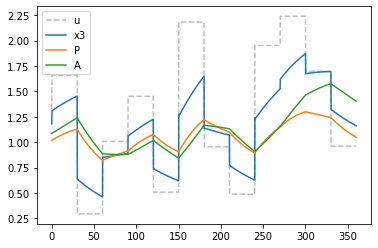

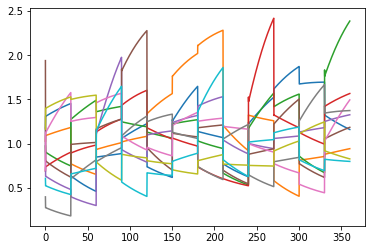

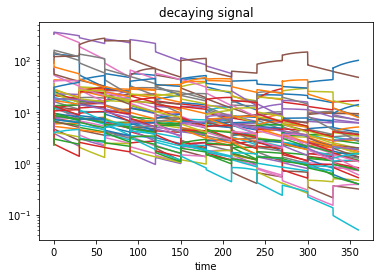

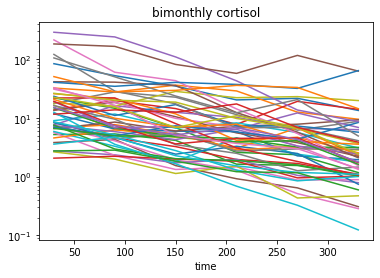

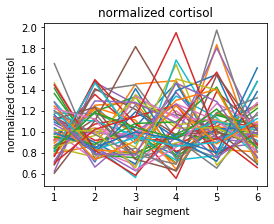

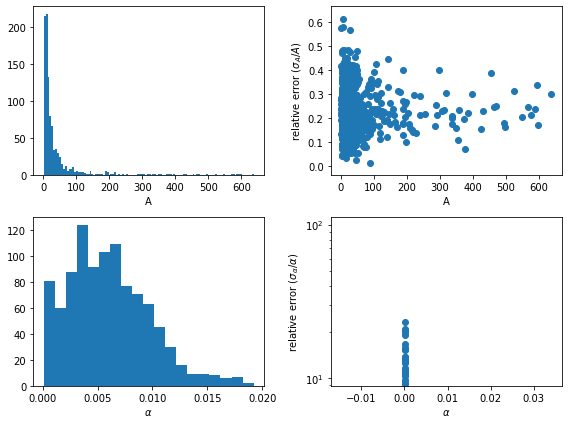

Mean personal decaying constant = 0.006
STD of personal decaying constants = 0.004
SEM = 0.00012


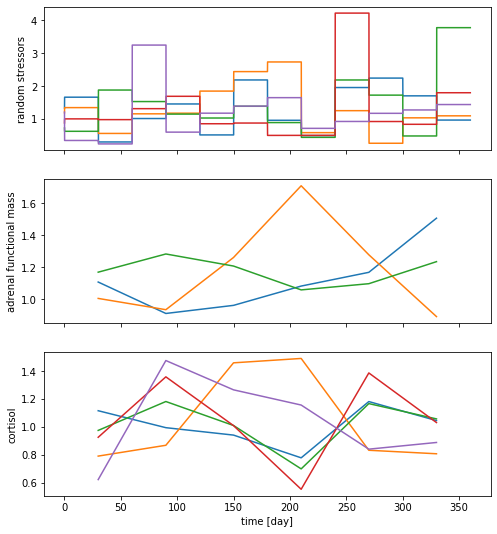


mean of CVs (cohort size of 55): 0.23, SE: 0.01


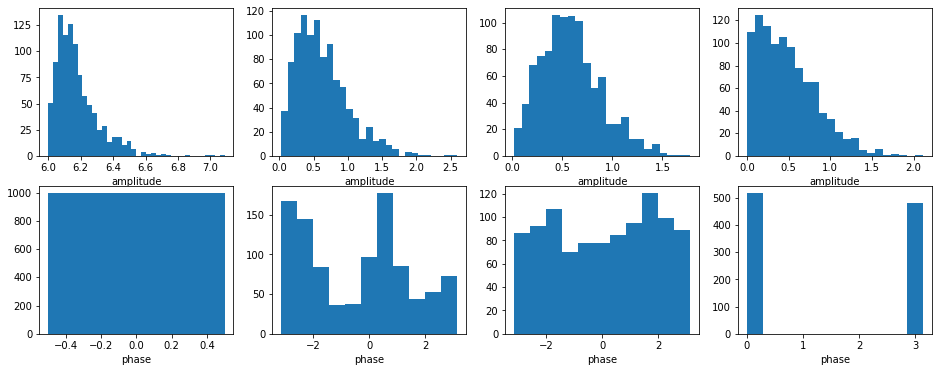

(4, 1000)


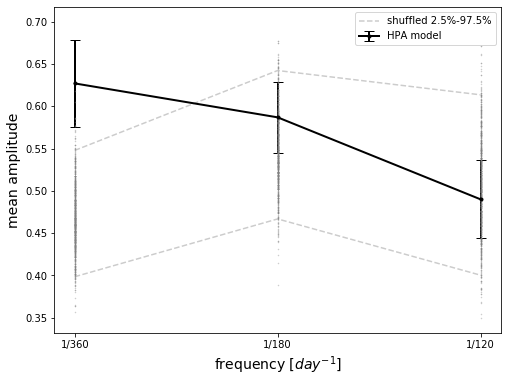

Amplitudes ratio = 1.28


In [15]:
pars.update({"gamma_P" : np.log(2)/30, "gamma_A" : np.log(2)/30}) # for the hair cortisol paper
full_HPA_analysis(
    model='o',
    u_func=ut,
    decline_path='../data/low_no_repeats.pkl', 
    res_path='',
    N_population=1000,
    fig_name='./results/figs/4b - hpa with gland dynamics fft.pdf',
)

{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.023104906018664842, 'gamma_A': 0.023104906018664842, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}


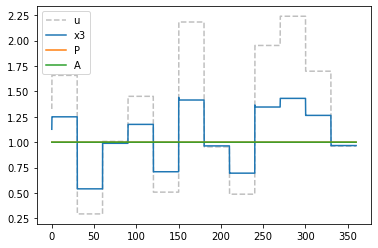

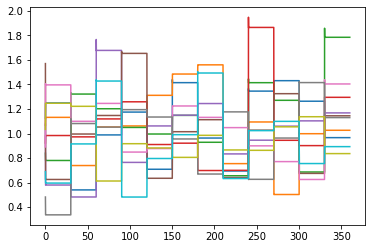

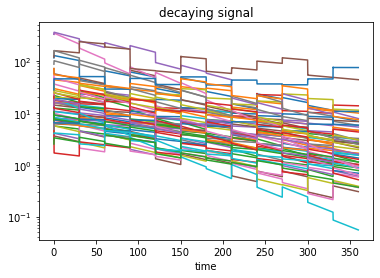

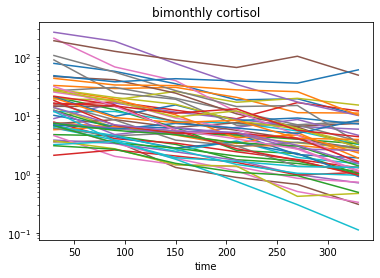

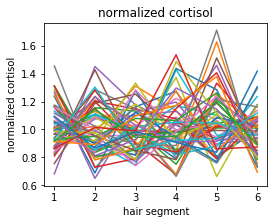

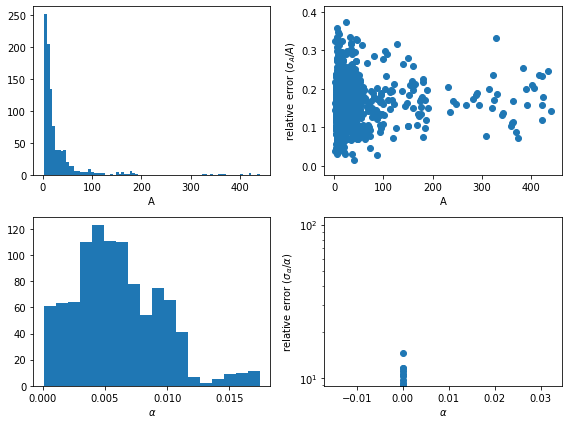

Mean personal decaying constant = 0.006
STD of personal decaying constants = 0.003
SEM = 0.00011


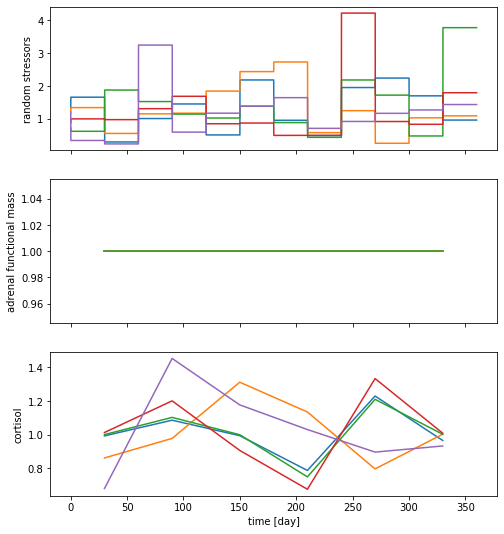


mean of CVs (cohort size of 55): 0.16, SE: 0.01


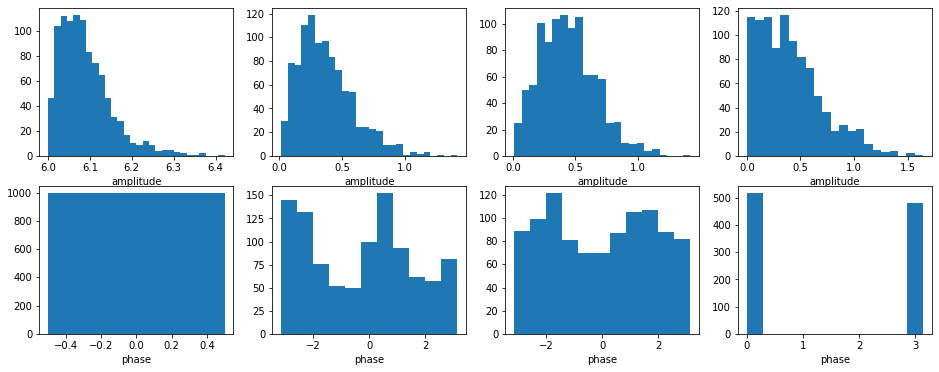

(4, 1000)


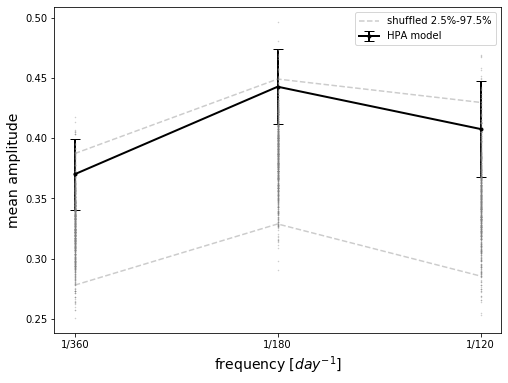

Amplitudes ratio = 0.91


In [16]:
full_HPA_analysis(
    model='fo',
    u_func=ut,
    decline_path='../data/low_no_repeats.pkl', 
    res_path='',
    N_population=1000,
    fig_name='./results/figs/4a - hpa no gland dynamics fft.pdf',
)

# Sensitivity analysis

In [107]:
omer_pars = dict(   # days
    [
        ("gamma_h", np.log(2)/4*24*60),
        ("gamma_p", np.log(2)/20*24*60),
        ("gamma_a", np.log(2)/80*24*60),
        ("gamma_P", np.log(2)/7),
        ("gamma_A", np.log(2)/14),
        ("gamma_R", 0),
        ("gamma_CR", 0),
        ("gamma_external_CRH", np.log(2)/43*24*60)
    ]
)
omer_pars

{'gamma_h': 249.5329850015803,
 'gamma_p': 49.906597000316054,
 'gamma_a': 12.476649250079014,
 'gamma_P': 0.09902102579427789,
 'gamma_A': 0.049510512897138946,
 'gamma_R': 0,
 'gamma_CR': 0,
 'gamma_external_CRH': 23.21237069782142}

In [115]:
factors = np.array([2**i for i in range(-5, 6)])
all_params = np.array(
    [
        omer_pars['gamma_h']*factors,
        omer_pars['gamma_p']*factors,
        omer_pars['gamma_a']*factors,
        1/29*factors,
        1/29*factors
    ]
)
amp_ratio = []
for pars_x, par_name in zip(all_params, ['gamma_h', 'gamma_p', 'gamma_a', 'gamma_P', 'gamma_A']):
    pars = omer_pars.copy()
    pars.update({"gamma_P" : 1/29, "gamma_A" : 1/29}) # according to the resonanse frequency of 1 year - linearized analysis
    for par in tqdm_notebook(pars_x):
        pars.update({par_name: par})
        try:
            t_bimonths, normalized_cortisol = simulate_hair_experiment(
                model='o',
                N_inputs=55,
                u_func=ut,
                decline_path='../data/low_no_repeats.pkl',
                plot=False
            )
        except Exception as e:
            print(e)
            amp_ratio.append(np.NaN)
            continue

        fft = np.fft.rfft(normalized_cortisol, axis=0)
        amps = np.abs(fft)
        amp_ratio.append(np.mean(amps[1, :]) / np.mean(amps[3, :]))

[Errno 2] No such file or directory: ''
{'gamma_h': 7.797905781299384, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'gamma_h': 15.595811562598769, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'gamma_h': 31.191623125197538, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'ga

C:\Users\tomerm\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log


array must not contain infs or NaNs
[Errno 2] No such file or directory: ''
{'gamma_h': 7985.05552005057, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}
array must not contain infs or NaNs



[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 1.5595811562598767, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 3.1191623125197534, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 6.238324625039507, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'gamma

[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 0.3898952890649692, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 0.7797905781299383, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 1.5595811562598767, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.27, SE: 0.02
[Errno 2] No such file or directory: ''
{'gamm

[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.0010775862068965517, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.21, SE: 0.01
[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.0021551724137931034, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.21, SE: 0.01
[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.004310344827586207, 'gamma_A': 0.034482758620689655, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.21, SE: 0.01
[Errno 2] No such file or directory: ''
{'ga

[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.0010775862068965517, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.21, SE: 0.01
[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.0021551724137931034, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.21, SE: 0.01
[Errno 2] No such file or directory: ''
{'gamma_h': 249.5329850015803, 'gamma_p': 49.906597000316054, 'gamma_a': 12.476649250079014, 'gamma_P': 0.034482758620689655, 'gamma_A': 0.004310344827586207, 'gamma_R': 0, 'gamma_CR': 0, 'gamma_external_CRH': 23.21237069782142}

mean of CVs (cohort size of 55): 0.22, SE: 0.01
[Errno 2] No such file or directory: ''
{'ga

In [116]:
amp_ratio = np.array(amp_ratio)
amp_ratio.resize(all_params.shape)

In [117]:
amp_ratio.shape

(5, 11)

In [118]:
amp_ratio

array([[1.36777382, 1.36741333, 1.367237  , 1.36717013, 1.36716128,
        1.36716452, 1.36716698, 1.36716827, 1.36716892,        nan,
               nan],
       [1.36821145, 1.36782601, 1.36744115, 1.367251  , 1.36716946,
        1.36716452, 1.36719261, 1.36721004, 1.36721835, 1.36722242,
        1.36722445],
       [1.36849557, 1.36830853, 1.36830191, 1.36768515, 1.36731433,
        1.36716452, 1.36717043, 1.36725594, 1.36727452, 1.36728452,
        1.36729035],
       [1.21987338, 1.23006942, 1.25243007, 1.2996884 , 1.36492927,
        1.36716452, 1.2170188 , 1.07606208, 1.03224438, 1.02639558,
        1.02486188],
       [1.24979749, 1.26107755, 1.28490263, 1.32890304, 1.3827892 ,
        1.36716452, 1.22193816, 1.10216057, 1.06583288, 1.05974515,
        1.05702788]])

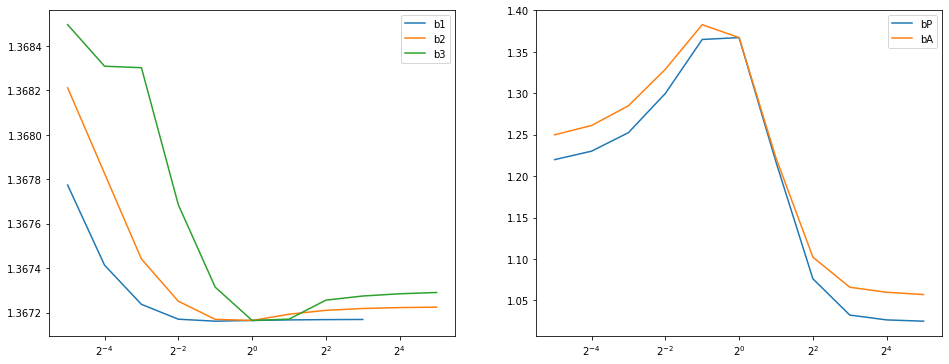

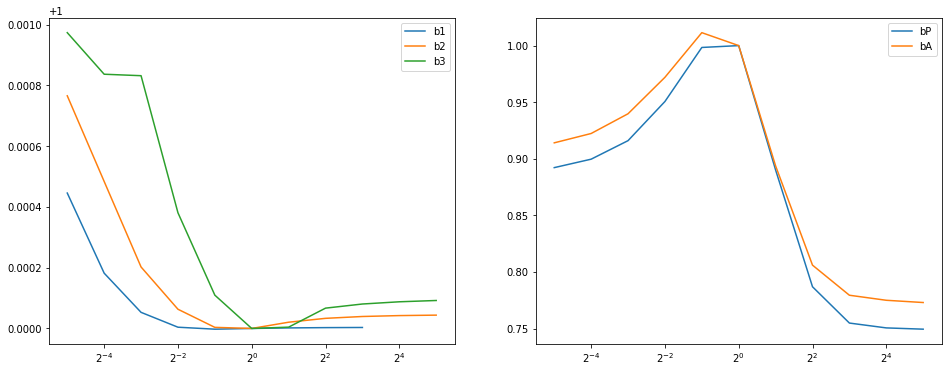

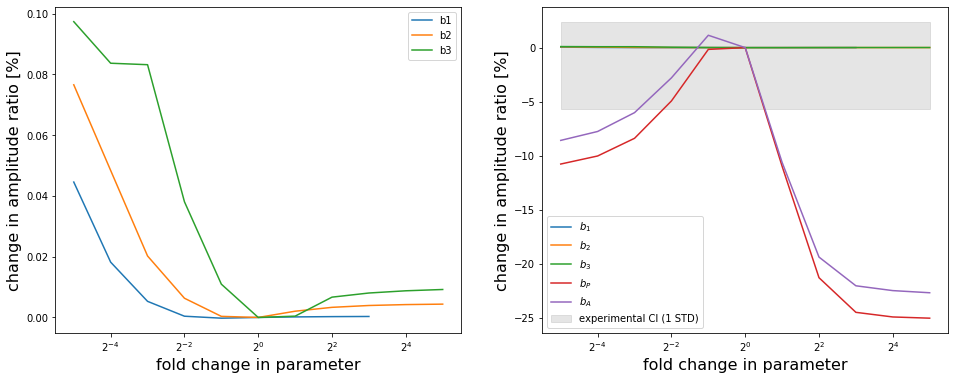

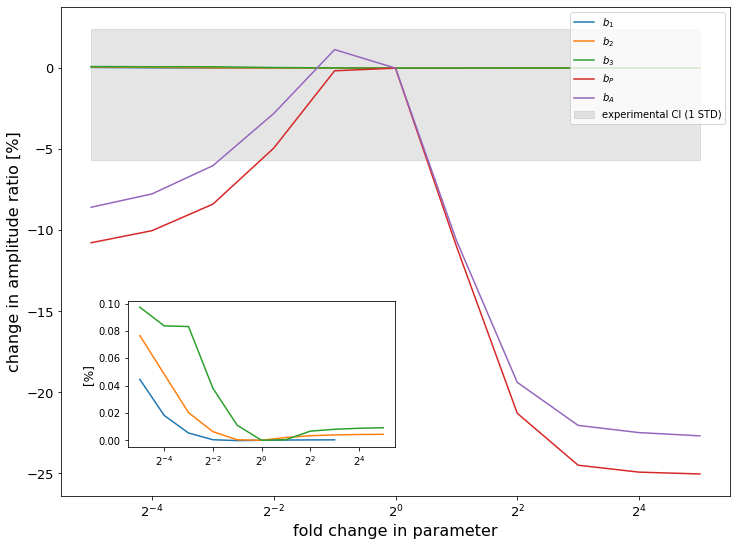

In [178]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4*2*2, 3*2))
ax[0].plot(factors, amp_ratio[:3].T)
ax[0].legend(['b1', 'b2', 'b3'])
ax[0].set_xscale('log', basex=2)
ax[1].plot(factors, amp_ratio[3:].T)
ax[1].legend(['bP','bA'])
ax[1].set_xscale('log', basex=2)
plt.show()

ratio_fold = amp_ratio / amp_ratio[0, 5]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4*2*2, 3*2))
ax[0].plot(factors, ratio_fold[:3].T)
ax[0].legend(['b1', 'b2', 'b3'])
ax[0].set_xscale('log', basex=2)
# ax[0].set_yscale('log', basey=10)
ax[1].plot(factors, ratio_fold[3:].T)
ax[1].legend(['bP','bA'])
ax[1].set_xscale('log', basex=2)
# ax[1].set_yscale('log', basey=10)
plt.show()

ratio_perc = 100*(amp_ratio - amp_ratio[0, 5]) / amp_ratio[0, 5]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4*2*2, 3*2))
ax[0].plot(factors, ratio_perc[:3].T)
ax[0].legend(['b1', 'b2', 'b3'])
ax[0].set_xscale('log', basex=2)
ax[0].set_xlabel('fold change in parameter', size=16)
ax[0].set_ylabel('change in amplitude ratio [%]', size=16)
# ax[0].set_yscale('log', basey=10)

# ax[1].plot(factors, ratio_perc[3:].T)
# ax[1].legend(['bP','bA'])

for perc, label in zip(ratio_perc, ['$b_1$', '$b_2$', '$b_3$', '$b_P$','$b_A$']):
    ax[1].plot(factors, perc, label=label)

ax[1].set_xscale('log', basex=2)
ax[1].set_xlabel('fold change in parameter', size=16)
ax[1].set_ylabel('change in amplitude ratio [%]', size=16)
# up = 100*(1.63 - amp_ratio[0, 5]) / amp_ratio[0, 5]
up = 100*(1.4 - amp_ratio[0, 5]) / amp_ratio[0, 5]
down = 100*(1.29 - amp_ratio[0, 5]) / amp_ratio[0, 5]
plt.fill_between(x=factors, y1=up, y2=down, color='gray', alpha=0.2, label='experimental CI (1 STD)')
ax[1].legend()
plt.show()






fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4*3, 3*3))
for perc, label in zip(ratio_perc, ['$b_1$', '$b_2$', '$b_3$', '$b_P$','$b_A$']):
    ax1.plot(factors, perc, label=label)

ax1.set_xscale('log', basex=2)
ax1.set_xlabel('fold change in parameter', size=16)
ax1.set_ylabel('change in amplitude ratio [%]', size=16)
up = 100*(1.4 - amp_ratio[0, 5]) / amp_ratio[0, 5]
down = 100*(1.29 - amp_ratio[0, 5]) / amp_ratio[0, 5]
plt.fill_between(x=factors, y1=up, y2=down, color='gray', alpha=0.2, label='experimental CI (1 STD)')


ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.1, 0.1, 0.4, 0.3])
ax2.set_axes_locator(ip)
# mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

ax2.plot(factors, ratio_perc[:3].T)
ax2.set_xscale('log', basex=2)
ax2.set_ylabel('[%]', size=12)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='major', labelsize=13)

ax1.legend(loc='upper right') #,framealpha )
# plt.savefig('./results/figs/sensitivity analysis.pdf', transparent=True)

# Linearized HPA transfer functions

In [5]:
def hpa_transfer_function(b1, b2, b3, ba, bp, model='a', w=None, plot=False):
    '''
    @params:
        model - 'a' for avichai, 'o' for omer
    '''
    
    if model == 'a':
        x1_num = [0, b1,           b1*(b2 + b3),           2*b1*b2*b3,          b1*b2*b3*ba,               0]
        x2_num = [0, 0,            b1*b2,                  b1*b2*b3 + b1*b2*bp, b1*b2*b3*bp,               0]
        x3_num = [0, 0,            0,                      b1*b2*b3,            b1*b2*b3*ba + b1*b2*b3*bp, b1*b2*b3*ba*bp]
        p_num =  [0, 0,            b1*bp,                  b1*(b2 + b3)*bp,     2*b1*b2*b3*bp,             b1*b2*b3*ba*bp]
        a_num =  [0, 0,            0,                      b1*b2*ba,            b1*b2*b3*ba + b1*b2*ba*bp, b1*b2*b3*ba*bp]
        den =    [1, b1 + b2 + b3, 2*b2*b3 + b1*(b2 + b3), b2*b3*(3*b1 + ba),   b1*b2*b3*(2*ba + bp),      b1*b2*b3*ba*bp]
        
    elif model == 'o':
        x1_num = [0, b1,           b1*(b2 + b3),           b1*b2*b3,            0,                         0]
        x2_num = [0, 0,            b1*b2,                  b1*b2*b3 + b1*b2*bp, b1*b2*b3*bp,               0]
        x3_num = [0, 0,            0,                      b1*b2*b3,            b1*b2*b3*ba + b1*b2*b3*bp, b1*b2*b3*ba*bp]
        p_num =  [0, 0,            b1*bp,                  b1*(b2 + b3)*bp,     b1*bp*b2*b3,               0]
        a_num =  [0, 0,            0,                      b1*b2*ba,            b1*b2*b3*ba + b1*b2*ba*bp, b1*b2*b3*ba*bp]
        den =    [1, b1 + b2 + b3, b1*b2+b1*b3+b2*b3,      2*b1*b2*b3,          b1*b2*b3*(ba + bp),        b1*b2*b3*ba*bp]
        
    else:
        raise TypeError('model should be \'a\' (for avichai) or \'o\' for omer, given: {}'.format(model))
            
    
    var_nums = [x1_num, x2_num, x3_num, p_num, a_num]
    var_names = ['x1', 'x2', 'x3', 'P', 'A']
    
    tfs = [signal.TransferFunction(num, den) for num in var_nums]
    w_mag_phases = [tf.bode(w=w) for tf in tfs]
    
    if plot:
        f, axs = plt.subplots(2, len(w_mag_phases), sharex=True, figsize=(4*len(w_mag_phases), 2*3))
        experimental_freqs = 2*np.pi*np.array([1/360, 1/180, 1/120])
        for i, w_mag_phase in enumerate(w_mag_phases):
            axs[0, i].semilogx(w_mag_phase[0], w_mag_phase[1])
            [axs[0, i].axvline(freq, color='grey', linestyle='--', alpha=0.6) for freq in experimental_freqs]
            axs[0, i].xaxis.set_tick_params(labelbottom=True)
            axs[0, i].set_ylabel('Gain [dB]')
            axs[0, i].set_title(var_names[i])
            
            axs[1, i].semilogx(w_mag_phase[0], w_mag_phase[2])
            [axs[1, i].axvline(freq, color='grey', linestyle='--', alpha=0.6) for freq in experimental_freqs]
            axs[1, i].set_xlabel('Frequency [rad/day]')
            axs[1, i].set_ylabel('Phase [deg]')
        plt.tight_layout()
        
        plt.figure(figsize=(4*2, 3*2))
        x3_amps = np.exp(w_mag_phases[2][1]/20)
        freqs = w_mag_phases[2][0] / (2*np.pi)
        plt.plot(freqs, x3_amps)
        [plt.axvline(freq, color='grey', linestyle='--') for freq in experimental_freqs/(2*np.pi)]
        plt.ylabel('$amplitude$', size=16)
        plt.xlabel('$frequency\ [day^{-1}]$', size=16)
#         plt.title(var_names[2])
        plt.xscale('log')
        
    return w_mag_phases

C:\Users\tomerm\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


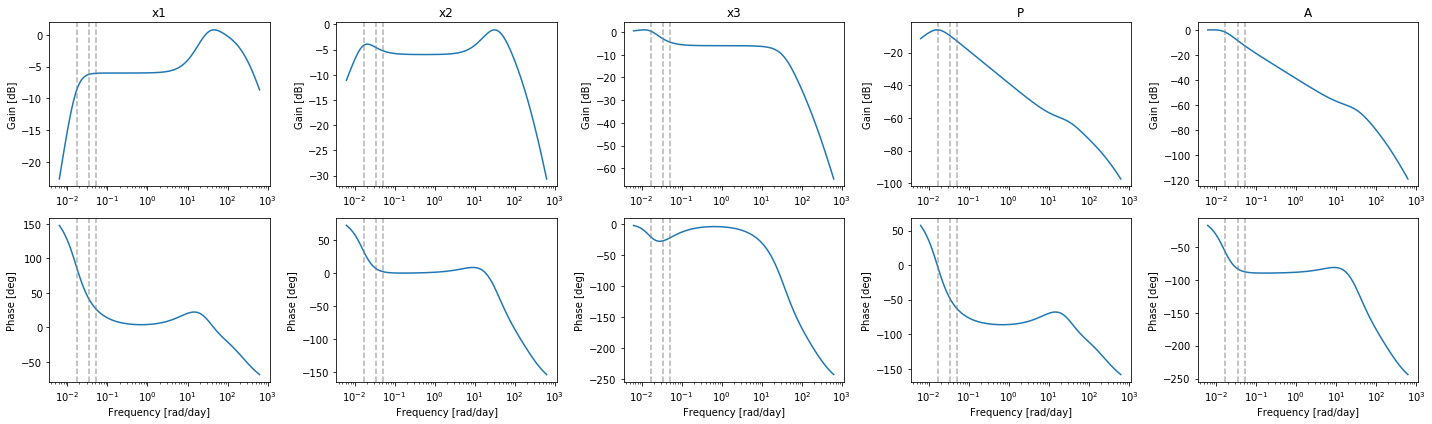

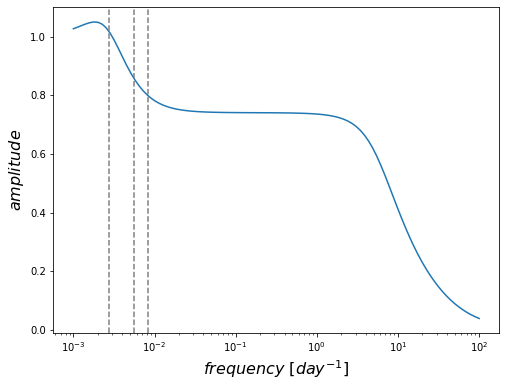

In [6]:
b1 = np.log(2)/4*24*60
b2 = np.log(2)/20*24*60
b3 = np.log(2)/80*24*60
ba = np.log(2)/30
bp = np.log(2)/30
w = 2*np.pi*10**(np.linspace(-3, 2, 100)) # [rad/day]

w_mag_phases = hpa_transfer_function(b1=b1, b2=b2, b3=b3, ba=ba, bp=bp, model='o', w=w, plot=True)
plt.savefig('../../../results/figs/fig s4 - frequency response.pdf', transparent=True, dpi=500)